# Model Selection & Training

**Objective:** Train and tune models to predict Airbnb new user booking destinations.

In this notebook, we will:
1. Load the preprocessed data
2. Split the data into training and validation sets
3. Train various machine learning models
4. Tune hyperparameters using cross-validation
5. Save the trained models for later evaluation

## 1. Import Required Libraries

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime

# Import ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# For hyperparameter optimization
import optuna

# Visualization settings
sns.set(style="whitegrid", palette="muted")

# Display progress bars for longer operations
from tqdm.notebook import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load Preprocessed Data

In [2]:
# Load the preprocessed training data
processed_data_path = '../data/processed/train_processed.csv'

if os.path.exists(processed_data_path):
    df = pd.read_csv(processed_data_path)
    print(f"Loaded preprocessed data with shape: {df.shape}")
else:
    print(f"Error: Preprocessed data file not found at {processed_data_path}")
    print("Please run the 03_preprocessing.ipynb notebook first.")

Loaded preprocessed data with shape: (213451, 197)


In [3]:
# Quick check of the data
df.head()

,id,age,signup_flow,country_destination,dac_year,dac_month,dac_day,dac_dayofweek,dac_is_weekend,dac_quarter,...,signup_method_flow_facebook_16,signup_method_flow_facebook_2,signup_method_flow_facebook_21,signup_method_flow_facebook_23,signup_method_flow_facebook_24,signup_method_flow_facebook_25,signup_method_flow_facebook_3,signup_method_flow_facebook_4,signup_method_flow_facebook_5,signup_method_flow_google_12
0,gxn3p5htnn,-0.164557,0,NDF,2010,6,28,0,0,2,...,False,False,False,False,False,False,False,False,False,False
1,820tgsjxq7,0.281566,0,NDF,2011,5,25,2,0,2,...,False,False,False,False,False,False,False,False,False,False
2,4ft3gnwmtx,2.289118,3,US,2010,9,28,1,0,3,...,False,False,False,False,False,False,False,False,False,False
3,bjjt8pjhuk,0.727688,0,other,2011,12,5,0,0,4,...,False,False,False,False,False,False,False,False,False,False
4,87mebub9p4,0.616158,0,US,2010,9,14,1,0,3,...,False,False,False,False,False,False,False,False,False,False


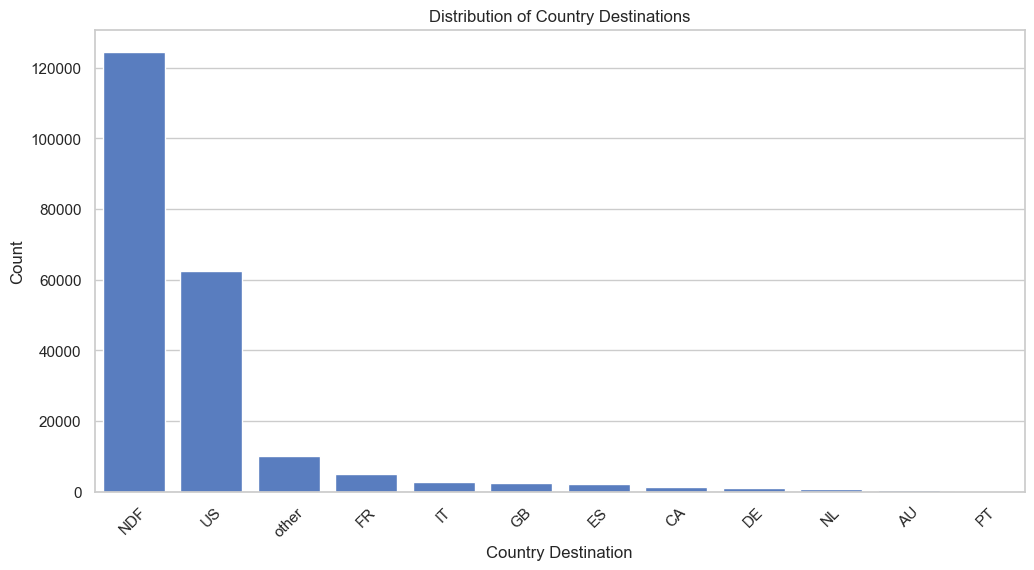

Class distribution:
country_destination
NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: proportion, dtype: float64


In [4]:
# Distribution of target variable
plt.figure(figsize=(12, 6))
target_counts = df['country_destination'].value_counts()
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Country Destinations')
plt.xlabel('Country Destination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Print percentages
print("Class distribution:")
print(df['country_destination'].value_counts(normalize=True) * 100)

## 3. Prepare Data for Training

In [5]:
# Separate features and target variable
X = df.drop(['country_destination', 'id'], axis=1, errors='ignore')  # Drop target and user id
y = df['country_destination']

# Check for any string column (that's not boolean, object, or category type)
non_numeric_cols = X.select_dtypes(exclude=['number', 'bool']).columns.tolist()
categorical_cols = ['most_common_action']  # Add other special categorical columns here if needed

# Remove known categorical columns from the non-numeric list
non_numeric_cols = [col for col in non_numeric_cols if col not in categorical_cols]

if non_numeric_cols:
    print(f"Warning: Found non-numeric, non-boolean columns in preprocessed data: {non_numeric_cols}")
    print("These columns should have been encoded in the preprocessing notebook.")
else:
    print("Data is properly preprocessed with all features encoded.")

# Convert known categorical columns to numeric via encoding if they exist
for col in categorical_cols:
    if col in X.columns:
        print(f"Encoding categorical column: {col}")
        # Convert all values to string before encoding to handle mixed types
        X[col] = X[col].astype(str)
        # Use Label Encoding for most_common_action
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        print(f"Unique values in {col}: {X[col].nunique()}")

# Convert boolean columns to int
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    print(f"Converting {len(bool_cols)} boolean columns to int64 type for model compatibility")
    X[bool_cols] = X[bool_cols].astype('int64')

Data is properly preprocessed with all features encoded.
Encoding categorical column: most_common_action
Unique values in most_common_action: 165
Converting 171 boolean columns to int64 type for model compatibility
Unique values in most_common_action: 165
Converting 171 boolean columns to int64 type for model compatibility


In [6]:
# Encode target variable for model compatibility
from sklearn.preprocessing import LabelEncoder

# Create a label encoder for the target variable
target_encoder = LabelEncoder()
# Fit the encoder on all available classes
target_encoder.fit(y)

# Print the encoding mapping
print("Target class encoding mapping:")
for i, country in enumerate(target_encoder.classes_):
    print(f"{i}: {country}")

# Transform the target variables
y_encoded = target_encoder.transform(y)

Target class encoding mapping:
0: AU
1: CA
2: DE
3: ES
4: FR
5: GB
6: IT
7: NDF
8: NL
9: PT
10: US
11: other


In [7]:
# Split data into training and validation sets using stratified sampling
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Get the original labels for reference and visualization
y_train_original = target_encoder.inverse_transform(y_train)
y_val_original = target_encoder.inverse_transform(y_val)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (170760, 195), Validation set: (42691, 195)


In [8]:
# Check for any NaN values
print(f"NaN values in training features: {X_train.isna().sum().sum()}")
print(f"NaN values in validation features: {X_val.isna().sum().sum()}")

# Replace any remaining NaN values with 0
if X_train.isna().sum().sum() > 0:
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)

NaN values in training features: 0
NaN values in validation features: 0


## 4. Baseline Models

We'll start with simple baseline models before moving to more complex ones.

In [9]:
# Function to evaluate and display model performance
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # For visualization, convert encoded labels back to original country names
    y_val_original = target_encoder.inverse_transform(y_val)
    y_pred_original = target_encoder.inverse_transform(y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # Display confusion matrix
    cm = confusion_matrix(y_val_original, y_pred_original)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_val_original, y_pred_original))
    
    return model, accuracy, f1


Logistic Regression Results:
Accuracy: 0.5871
F1 Score (weighted): 0.4451


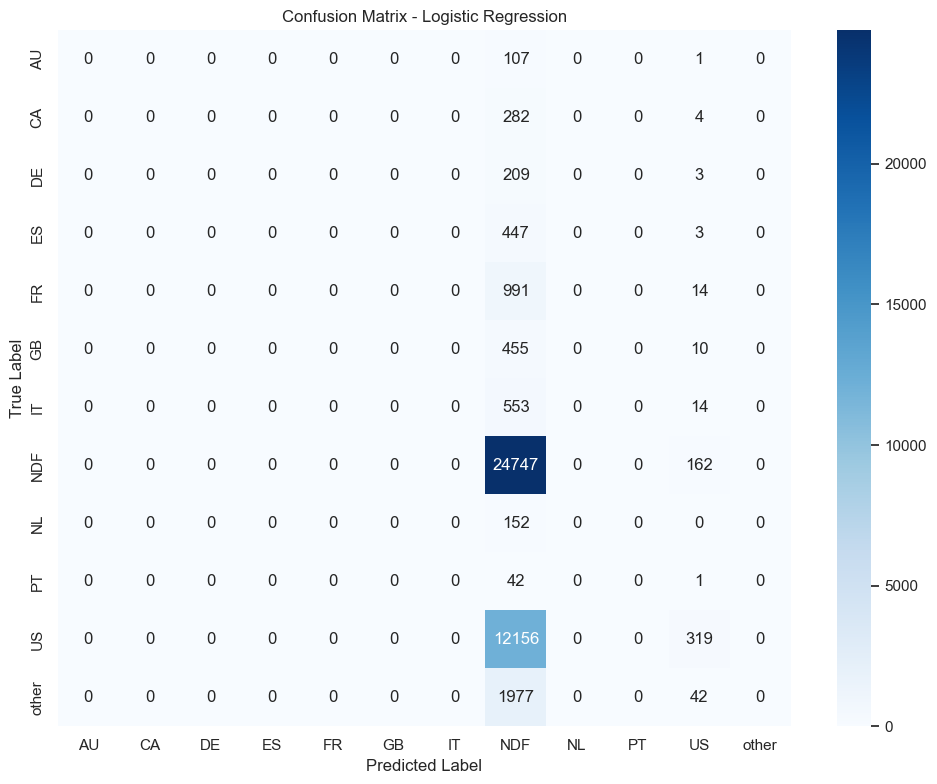


Classification Report:
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108
          CA       0.00      0.00      0.00       286
          DE       0.00      0.00      0.00       212
          ES       0.00      0.00      0.00       450
          FR       0.00      0.00      0.00      1005
          GB       0.00      0.00      0.00       465
          IT       0.00      0.00      0.00       567
         NDF       0.59      0.99      0.74     24909
          NL       0.00      0.00      0.00       152
          PT       0.00      0.00      0.00        43
          US       0.56      0.03      0.05     12475
       other       0.00      0.00      0.00      2019

    accuracy                           0.59     42691
   macro avg       0.10      0.08      0.07     42691
weighted avg       0.51      0.59      0.45     42691

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108


In [10]:
# 4.1 Logistic Regression (Baseline)
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
lr_model, lr_accuracy, lr_f1 = evaluate_model(lr_model, X_train, X_val, y_train, y_val, "Logistic Regression")


Random Forest Results:
Accuracy: 0.6233
F1 Score (weighted): 0.5734


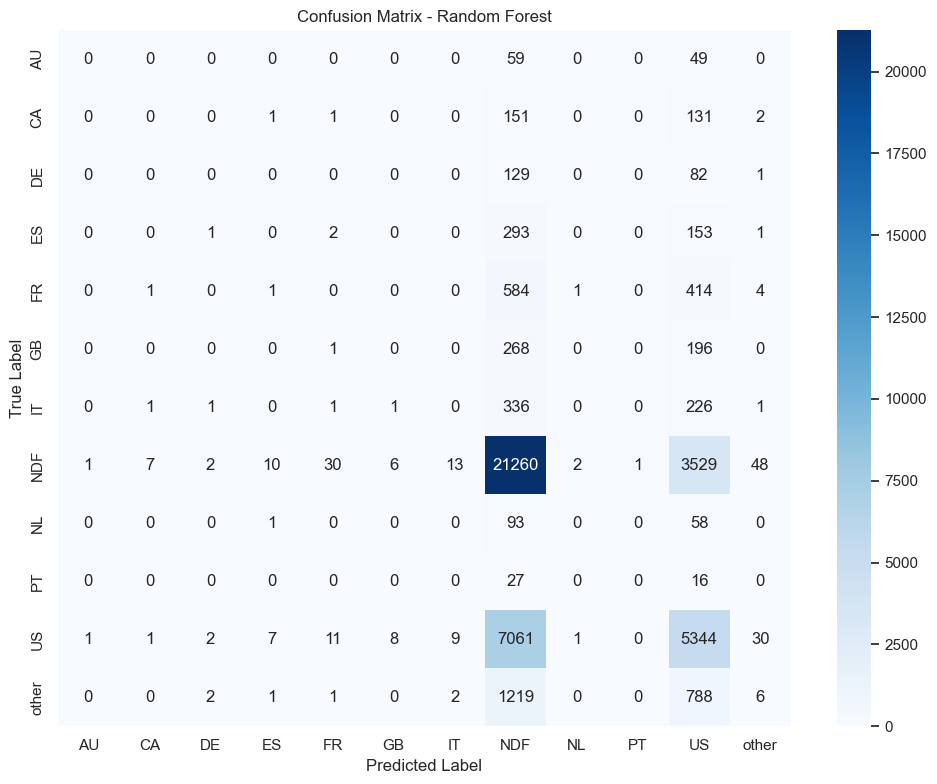


Classification Report:
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108
          CA       0.00      0.00      0.00       286
          DE       0.00      0.00      0.00       212
          ES       0.00      0.00      0.00       450
          FR       0.00      0.00      0.00      1005
          GB       0.00      0.00      0.00       465
          IT       0.00      0.00      0.00       567
         NDF       0.68      0.85      0.75     24909
          NL       0.00      0.00      0.00       152
          PT       0.00      0.00      0.00        43
          US       0.49      0.43      0.46     12475
       other       0.06      0.00      0.01      2019

    accuracy                           0.62     42691
   macro avg       0.10      0.11      0.10     42691
weighted avg       0.54      0.62      0.57     42691

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108


In [11]:
# 4.2 Random Forest (Baseline)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model, rf_accuracy, rf_f1 = evaluate_model(rf_model, X_train, X_val, y_train, y_val, "Random Forest")


XGBoost Results:
Accuracy: 0.6434
F1 Score (weighted): 0.5946


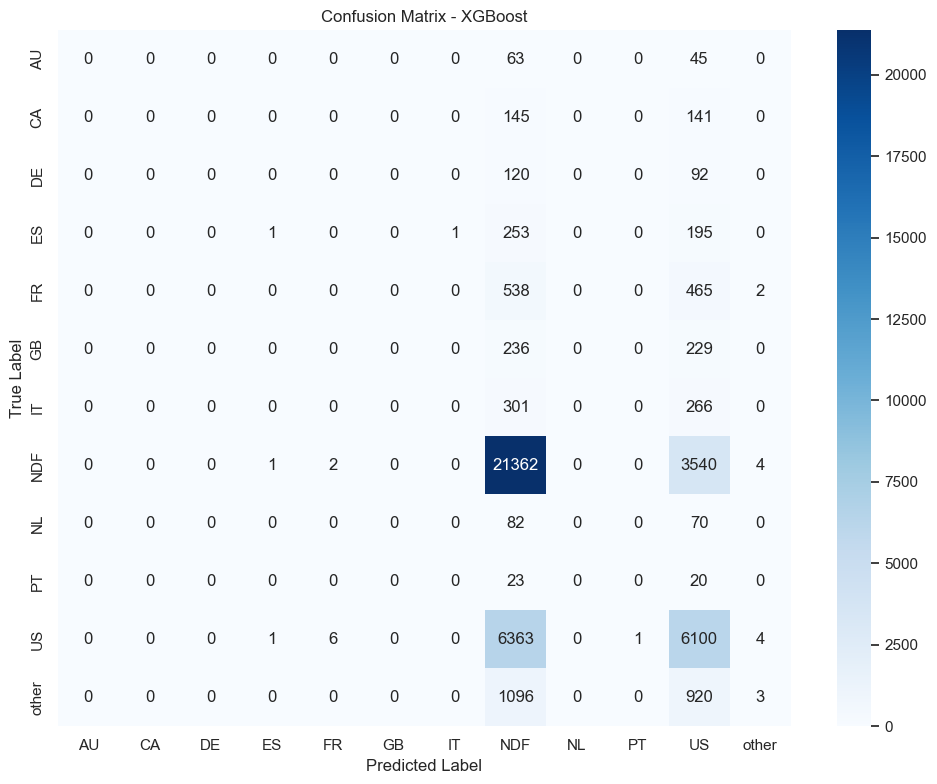


Classification Report:
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108
          CA       0.00      0.00      0.00       286
          DE       0.00      0.00      0.00       212
          ES       0.33      0.00      0.00       450
          FR       0.00      0.00      0.00      1005
          GB       0.00      0.00      0.00       465
          IT       0.00      0.00      0.00       567
         NDF       0.70      0.86      0.77     24909
          NL       0.00      0.00      0.00       152
          PT       0.00      0.00      0.00        43
          US       0.50      0.49      0.50     12475
       other       0.23      0.00      0.00      2019

    accuracy                           0.64     42691
   macro avg       0.15      0.11      0.11     42691
weighted avg       0.57      0.64      0.59     42691

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108


In [12]:
# 4.3 XGBoost (Baseline)
xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)
xgb_model, xgb_accuracy, xgb_f1 = evaluate_model(xgb_model, X_train, X_val, y_train, y_val, "XGBoost")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 170760, number of used features: 144
[LightGBM] [Info] Start training from score -5.981906
[LightGBM] [Info] Start training from score -5.007478
[LightGBM] [Info] Start training from score -5.303955
[LightGBM] [Info] Start training from score -4.553028
[LightGBM] [Info] Start training from score -3.749475
[LightGBM] [Info] Start training from score -4.520220
[LightGBM] [Info] Start training from score -4.321361
[LightGBM] [Info] Start training from score -0.538756
[LightGBM] [Info] Start training from score -5.634555
[LightGBM] [Info] Start training from score -6.888959
[LightGBM] [Info] Start t

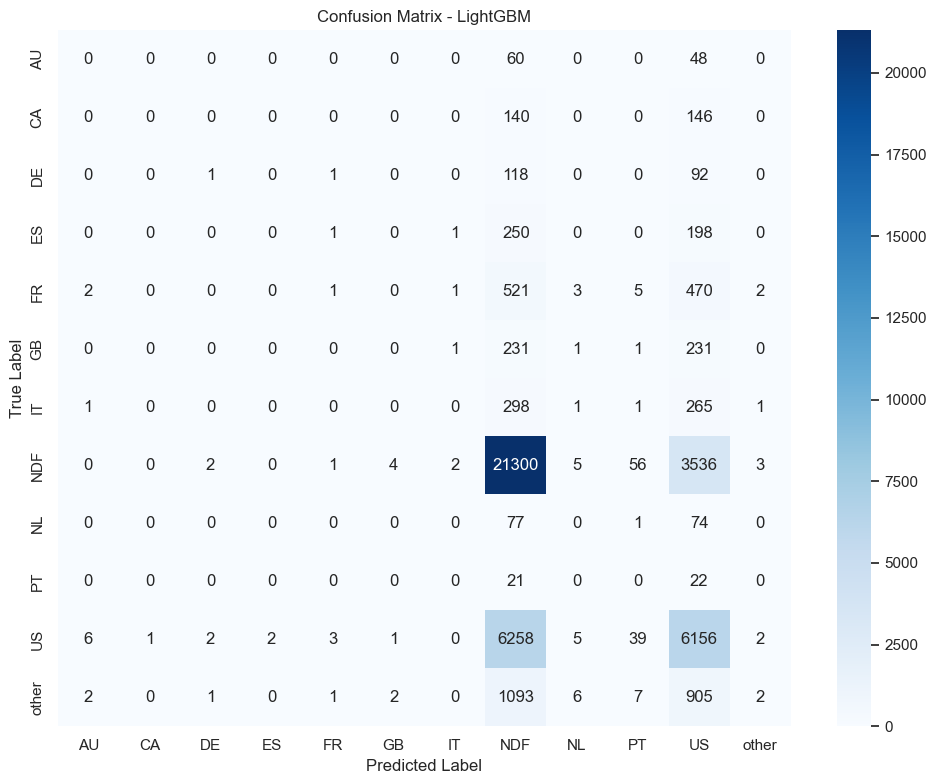


Classification Report:
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108
          CA       0.00      0.00      0.00       286
          DE       0.17      0.00      0.01       212
          ES       0.00      0.00      0.00       450
          FR       0.12      0.00      0.00      1005
          GB       0.00      0.00      0.00       465
          IT       0.00      0.00      0.00       567
         NDF       0.70      0.86      0.77     24909
          NL       0.00      0.00      0.00       152
          PT       0.00      0.00      0.00        43
          US       0.51      0.49      0.50     12475
       other       0.20      0.00      0.00      2019

    accuracy                           0.64     42691
   macro avg       0.14      0.11      0.11     42691
weighted avg       0.57      0.64      0.60     42691

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       108


In [13]:
# 4.4 LightGBM (Baseline)
lgb_model = lgb.LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1)
lgb_model, lgb_accuracy, lgb_f1 = evaluate_model(lgb_model, X_train, X_val, y_train, y_val, "LightGBM")

In [14]:
# Compare baseline models
baseline_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy, lgb_accuracy],
    'F1 Score': [lr_f1, rf_f1, xgb_f1, lgb_f1]
}

baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
baseline_df

,Model,Accuracy,F1 Score
0,LightGBM,0.643227,0.595998
1,XGBoost,0.643367,0.594585
2,Random Forest,0.623316,0.573358
3,Logistic Regression,0.587150,0.445135


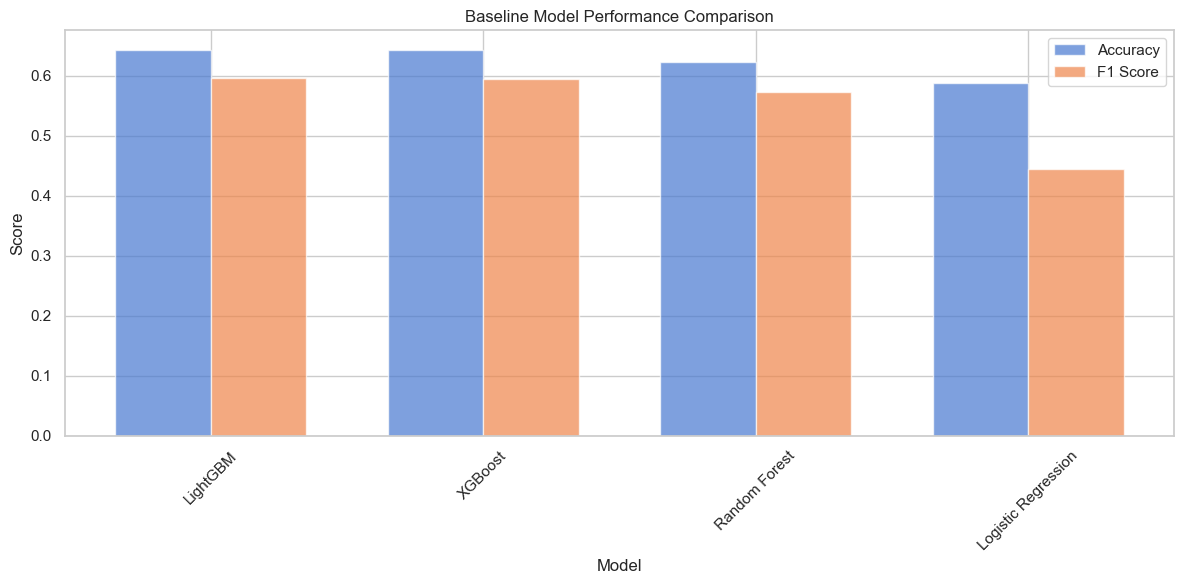

In [15]:
# Visualize baseline model comparison
plt.figure(figsize=(12, 6))

x = baseline_df['Model']
width = 0.35

plt.bar(x=np.arange(len(x)), height=baseline_df['Accuracy'], width=width, label='Accuracy', alpha=0.7)
plt.bar(x=np.arange(len(x)) + width, height=baseline_df['F1 Score'], width=width, label='F1 Score', alpha=0.7)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Baseline Model Performance Comparison')
plt.xticks(np.arange(len(x)) + width/2, x, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Feature Importance Analysis

Let's analyze feature importance for the best-performing model from our baselines.

In [16]:
# Function to plot feature importance
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For linear models like Logistic Regression
        importances = np.mean(np.abs(model.coef_), axis=0)
    else:
        print(f"Model {model_name} does not have feature importances available.")
        return
    
    # Get feature importances and names
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance and get top N
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Top {top_n} Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

Best performing baseline model: LightGBM


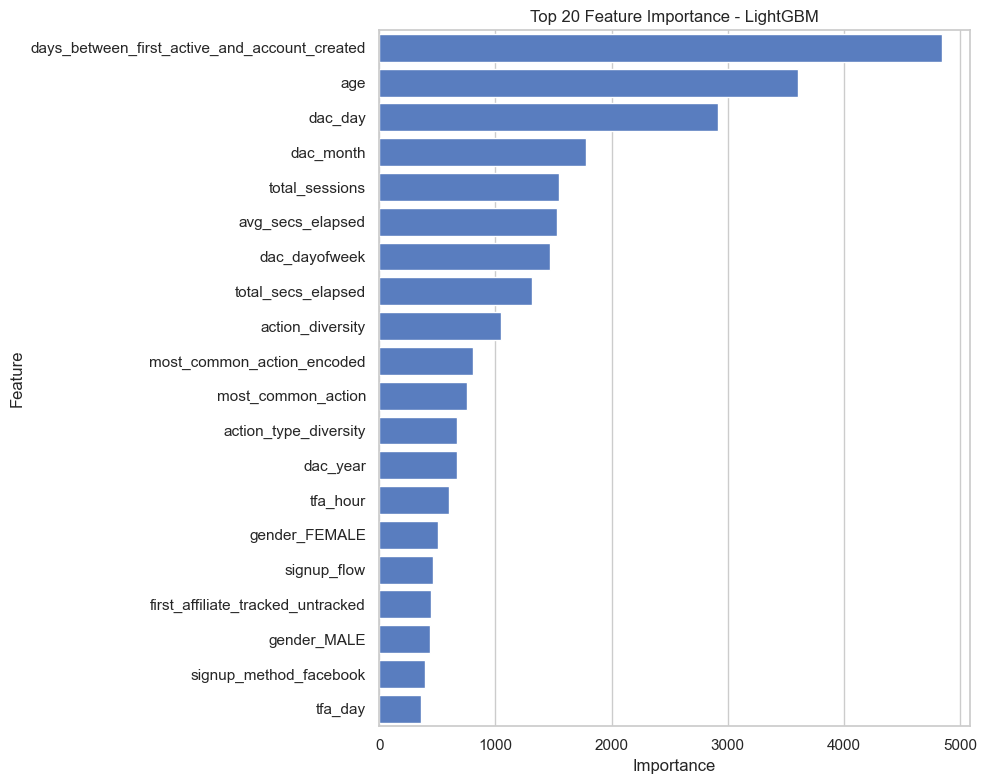

In [17]:
# Identify the best model from baselines
best_baseline_model_name = baseline_df.iloc[0]['Model']
print(f"Best performing baseline model: {best_baseline_model_name}")

# Get the corresponding model object
if best_baseline_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_baseline_model_name == 'Random Forest':
    best_model = rf_model
elif best_baseline_model_name == 'XGBoost':
    best_model = xgb_model
else:  # LightGBM
    best_model = lgb_model

# Plot feature importance for the best model
feature_importance_df = plot_feature_importance(best_model, X_train.columns, best_baseline_model_name)

## 6. Hyperparameter Tuning with Cross-Validation

Let's tune the hyperparameters of our best-performing model to improve its performance.

In [18]:
# Find best baseline model to tune
best_model_name = best_baseline_model_name
print(f"Tuning hyperparameters for: {best_model_name}")

Tuning hyperparameters for: LightGBM


In [19]:
# 6.1 Tuning Random Forest (if it's the best model)
if best_model_name == 'Random Forest':
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    # Create model
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Use cross-validation with grid search
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, 
                              scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    # Train with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_rf = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model, tuned_accuracy, tuned_f1 = evaluate_model(best_rf, X_train, X_val, y_train, y_val, "Tuned Random Forest")

In [20]:
# 6.2 Tuning XGBoost (if it's the best model)
if best_model_name == 'XGBoost':
    # Define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }
    
    # Create model
    xgb_clf = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)
    
    # Use cross-validation with grid search
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=cv, 
                              scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    # Train with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_xgb = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model, tuned_accuracy, tuned_f1 = evaluate_model(best_xgb, X_train, X_val, y_train, y_val, "Tuned XGBoost")

In [ ]:
# 6.3 Tuning LightGBM (if it's the best model)
if best_model_name == 'LightGBM':
    # Define parameter grid
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],  # -1 means no limit
        'num_leaves': [31, 63, 127],
        'subsample': [0.7, 0.8, 0.9]
    }
    
    # Create model
    lgbm = lgb.LGBMClassifier(objective='multiclass', random_state=42, n_jobs=-1)
    
    # Use cross-validation with grid search
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=cv, 
                              scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    # Train with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_lgbm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model, tuned_accuracy, tuned_f1 = evaluate_model(best_lgbm, X_train, X_val, y_train, y_val, "Tuned LightGBM")

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [ ]:
# 6.4 Tuning Logistic Regression (if it's the best model)
if best_model_name == 'Logistic Regression':
    # Define parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l2', 'none']
    }
    
    # Create model
    lr = LogisticRegression(max_iter=2000, multi_class='multinomial', random_state=42)
    
    # Use cross-validation with grid search
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=cv, 
                              scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    # Train with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model and parameters
    best_lr = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model, tuned_accuracy, tuned_f1 = evaluate_model(best_lr, X_train, X_val, y_train, y_val, "Tuned Logistic Regression")

## 7. Advanced Hyperparameter Tuning with Optuna

Now let's use Optuna to perform more sophisticated hyperparameter optimization for our best model.

In [ ]:
# Define the objective function for XGBoost
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'objective': 'multi:softmax',
        'random_state': 42
    }
    
    # Create model
    model = xgb.XGBClassifier(**param)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
    
    # Return mean CV score
    return cv_scores.mean()

In [ ]:
# Define the objective function for LightGBM
def objective_lgb(trial):
    param = {
        'objective': 'multiclass',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42
    }
    
    # Create model
    model = lgb.LGBMClassifier(**param)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
    
    # Return mean CV score
    return cv_scores.mean()

In [ ]:
# Define the objective function for RandomForest
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }
    
    # Create model
    model = RandomForestClassifier(**param)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')
    
    # Return mean CV score
    return cv_scores.mean()

In [ ]:
# Choose which objective function to use based on best baseline model
if best_model_name == 'XGBoost':
    objective_function = objective_xgb
    print("Running Optuna optimization for XGBoost...")
elif best_model_name == 'LightGBM':
    objective_function = objective_lgb
    print("Running Optuna optimization for LightGBM...")
elif best_model_name == 'Random Forest':
    objective_function = objective_rf
    print("Running Optuna optimization for Random Forest...")
else:
    # For Logistic Regression, we'll use GridSearchCV results
    print("Skipping Optuna optimization for Logistic Regression (GridSearchCV is sufficient)")

In [ ]:
# Run Optuna optimization if applicable
if best_model_name in ['XGBoost', 'LightGBM', 'Random Forest']:
    # Create study
    study = optuna.create_study(direction='maximize')
    
    # Optimize with 50 trials (adjust as needed)
    study.optimize(objective_function, n_trials=50)
    
    # Print best parameters
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Create model with best parameters
    if best_model_name == 'XGBoost':
        final_model = xgb.XGBClassifier(
            objective='multi:softmax',
            random_state=42,
            **trial.params
        )
    elif best_model_name == 'LightGBM':
        final_model = lgb.LGBMClassifier(
            objective='multiclass',
            random_state=42,
            **trial.params
        )
    else:  # Random Forest
        final_model = RandomForestClassifier(
            random_state=42,
            **trial.params
        )
    
    # Evaluate final model
    final_model, final_accuracy, final_f1 = evaluate_model(
        final_model, X_train, X_val, y_train, y_val, f"Optuna-Tuned {best_model_name}"
    )
else:
    # For Logistic Regression, use the GridSearchCV results as the final model
    final_model = best_lr if 'best_lr' in locals() else lr_model
    final_accuracy = tuned_accuracy if 'tuned_accuracy' in locals() else lr_accuracy
    final_f1 = tuned_f1 if 'tuned_f1' in locals() else lr_f1

## 8. Retrain Final Model on Full Training Data

In [ ]:
# Retrain final model on the full training dataset
print(f"Training final {best_model_name} model on full training data...")
final_model.fit(X_train, y_train)

In [ ]:
# Save the final model
model_filename = f"../models/final_{best_model_name.lower().replace(' ', '_')}_model.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Final model saved to {model_filename}")

In [ ]:
# Save model metadata
model_meta = {
    'model_type': best_model_name,
    'accuracy': final_accuracy,
    'f1_score': final_f1,
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_file': model_filename,
    'feature_count': X_train.shape[1],
    'train_samples': X_train.shape[0],
    'validation_samples': X_val.shape[0],
    'classes': list(final_model.classes_)
}

meta_filename = "../models/model_metadata.json"
import json
with open(meta_filename, 'w') as f:
    json.dump(model_meta, f, indent=4)

print(f"Model metadata saved to {meta_filename}")

## 9. Final Performance on Validation Set

In [ ]:
# Make predictions on validation set
y_pred = final_model.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Final Model ({best_model_name}) Performance on Validation Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

In [ ]:
# Display final confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=final_model.classes_, yticklabels=final_model.classes_)
plt.title(f'Final Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f"../outputs/final_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Display classification report
print("Final Classification Report:")
print(classification_report(y_val, y_pred))

## 10. Predict Top 5 Countries (Kaggle Evaluation Metric)

The Kaggle competition uses NDCG@5 (Normalized Discounted Cumulative Gain) as the evaluation metric, so we need to predict the top 5 most likely destinations for each user.

In [ ]:
# Function to get top 5 predictions for each sample
def get_top5_predictions(model, X):
    # Get probability scores for each class
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X)
    else:
        # For models without predict_proba
        print("Warning: Model doesn't have predict_proba. Using alternative approach.")
        # Example alternative for XGBoost:
        if isinstance(model, xgb.XGBClassifier):
            proba = model.predict_proba(X)
        else:
            raise ValueError("Model doesn't support probability predictions")
    
    # Get classes
    classes = model.classes_
    
    # Get top 5 indices
    top5_indices = np.argsort(-proba, axis=1)[:, :5]
    
    # Convert indices to class labels
    top5_predictions = np.take(classes, top5_indices)
    
    return top5_predictions

In [ ]:
# Function to get top 5 predictions for each sample
def get_top5_predictions(model, X):
    # Get probability scores for each class
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X)
    else:
        # For models without predict_proba
        print("Warning: Model doesn't have predict_proba. Using alternative approach.")
        # Example alternative for XGBoost:
        if isinstance(model, xgb.XGBClassifier):
            proba = model.predict_proba(X)
        else:
            raise ValueError("Model doesn't support probability predictions")
    
    # Get top 5 indices
    top5_indices = np.argsort(-proba, axis=1)[:, :5]
    
    # Convert indices to original class labels
    top5_predictions = target_encoder.inverse_transform(top5_indices.flatten()).reshape(top5_indices.shape)
    
    return top5_predictions

In [ ]:
# Get top 5 predictions for validation set
top5_preds = get_top5_predictions(final_model, X_val)

# Check a few examples
for i in range(min(5, len(y_val))):
    print(f"Sample {i+1}:")
    print(f"True destination: {y_val.iloc[i]}")
    print(f"Top 5 predictions: {top5_preds[i]}")
    print("-" * 40)

In [ ]:
# Calculate how often the true label is in the top 5 predictions
hits = 0
for i, true_label in enumerate(y_val):
    if true_label in top5_preds[i]:
        hits += 1

top5_accuracy = hits / len(y_val)
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")

## 11. Summary of Results

Let's summarize our model training process and results.

In [ ]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (weighted)', 'Top-5 Accuracy'],
    'Value': [accuracy, f1, top5_accuracy]
})

print(f"Final Model: {best_model_name}")
summary

In [ ]:
# Plot final feature importance
if hasattr(final_model, 'feature_importances_') or hasattr(final_model, 'coef_'):
    feature_importance_df = plot_feature_importance(final_model, X_train.columns, f"Final {best_model_name}", top_n=20)
    
    # Save feature importance plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Top 20 Feature Importance - Final {best_model_name}')
    plt.tight_layout()
    plt.savefig("../outputs/feature_importance.png", dpi=300, bbox_inches='tight')
    plt.close()

## 12. Save Model Pipeline for Inference

Finally, let's save the complete pipeline for making predictions on new users.

In [ ]:
# Create a dictionary with all components needed for inference
pipeline_components = {
    'model': final_model,
    'feature_names': X_train.columns.tolist(),
    'target_classes': final_model.classes_.tolist()
}

# Save the pipeline
pipeline_filename = "../models/prediction_pipeline.pkl"
with open(pipeline_filename, 'wb') as f:
    pickle.dump(pipeline_components, f)

print(f"Prediction pipeline saved to {pipeline_filename}")